<a href="https://colab.research.google.com/github/FrancisRodr0010/Fundamentos-1er-Proyecto/blob/main/ProyectoIA_SP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto SP1 - Inteligencia Artificial
Francisco Rodríguez - 22001828

Douglas Pérez - 22003865

Isabel Páiz - 22001411

# 1) Introducción

En este espacio vamos a resolver un problema de inteligencia artificial. En nuestro caso se nos dió un problema de clasificación, cuyo data set está especializado en cartas de 'Magic: The Gathering'. El problema que vamos a resolver es predecir el tipo (rarity) de la tarjeta en base a sus especialidades y features.

# 2) Preparación y **Librerias**

In [ ]:

import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix


import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import seaborn as sns


import os

AUTOTUNE = tf.data.AUTOTUNE

# 3) Arquitectura #1

##3.1 Extracción de la data

In [ ]:
#extracting the data

raw_data_arch1 = pd.read_csv("MTG-OTJ-draft-card-ratings-2024-05-25.csv")

raw_data_arch1.head()

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Another Round,W,R,64972,6.27,7953,9.59,1690,3.6%,46.6%,259,NaN,402,NaN,661,40.4%,1029,50.6%,-10.2pp
1,Archangel of Tithes,W,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,54.6%,4325,55.8%,7277,55.3%,10927,52.9%,2.4pp
2,Armored Armadillo,W,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,50.0%,7265,50.8%,12686,50.4%,18704,51.3%,-0.9pp
3,Aven Interrupter,W,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,56.6%,10692,57.5%,18427,57.1%,26391,54.3%,2.8pp
4,Bounding Felidar,W,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,53.6%,20093,55.4%,33127,54.7%,52462,54.4%,0.3pp


##3.2 Pre-procesar la data

### 3.2.1 Quitando valores Nulos
Dentro de este dataset hay features que contienen valores nulos, como color, GP WR, ATA, OH WR, GD WR, GIH WR, GNS WR, y IWD

In [ ]:
no_null_dataset = raw_data_arch1.copy()


print(no_null_dataset.isna().sum())

Name         0
Color       46
Rarity       0
# Seen       0
ALSA         0
# Picked     0
ATA          1
# GP         0
% GP         0
GP WR        8
# OH         0
OH WR       31
# GD         0
GD WR       23
# GIH        0
GIH WR      16
# GNS        0
GNS WR      12
IWD         16
dtype: int64


In [ ]:

no_null_dataset = no_null_dataset.dropna()

no_null_dataset.head()

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
1,Archangel of Tithes,W,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,54.6%,4325,55.8%,7277,55.3%,10927,52.9%,2.4pp
2,Armored Armadillo,W,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,50.0%,7265,50.8%,12686,50.4%,18704,51.3%,-0.9pp
3,Aven Interrupter,W,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,56.6%,10692,57.5%,18427,57.1%,26391,54.3%,2.8pp
4,Bounding Felidar,W,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,53.6%,20093,55.4%,33127,54.7%,52462,54.4%,0.3pp
5,Bovine Intervention,W,U,136473,6.33,12508,9.99,18372,24.9%,50.7%,2815,46.7%,4488,51.0%,7303,49.4%,11046,51.6%,-2.3pp


### 3.2.2 Parseando porcentajes


In [ ]:


def parse_percentage(percentage_string):

  try:
    # Remove the "%" symbol and convert to a float.
    percentage_value = float(percentage_string[:-1])

    # Convert the percentage to a value between 0 and 1.
    return percentage_value / 100


  except (ValueError, IndexError):
    return None


Dentro de la columna de IWD lo que vamos a hacer es deshacernos del texto del final (e.g -1.4pp, 4.2pp, 3.2pp, etc.)

In [ ]:
def parse_IWD(IWD_string):

  try:

    IWD_value = float(IWD_string[:-2])


    return IWD_value

  except (ValueError, IndexError):
    return None

### 3.2.3 Rarity - Ordinal Encoding

In [ ]:
#unique values for rarity

no_null_dataset['Rarity'].unique()

array(['M', 'C', 'R', 'U'], dtype=object)

In [ ]:
# M -> Mythic
# R -> Rare
# U -> Uncommon
# C -> Common


def parse_rarity(rarity_string):

  if rarity_string == 'M':
    return 0
  elif rarity_string == 'R':
    return 1
  elif rarity_string == 'U':
    return 2
  elif rarity_string == 'C':
    return 3
  else:
    return None

  return None



### 3.2.4 Color - One Hot Encoding

In [ ]:
no_null_dataset['Color'].unique()

array(['W', 'U', 'B', 'R', 'G', 'BR', 'WRG', 'WU', 'BG', 'WB', 'UG', 'UR',
       'WR', 'RG', 'WG', 'WUB', 'UB', 'WUG', 'UBR', 'URG', 'WBG', 'UBG'],
      dtype=object)

In [ ]:
#applying one hot encoding to the Color column

no_null_dataset = pd.get_dummies(no_null_dataset, columns=['Color'])
no_null_dataset.head()

,Name,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,Archangel of Tithes,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,...,False,True,False,False,False,False,False,False,False,False
2,Armored Armadillo,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,...,False,True,False,False,False,False,False,False,False,False
3,Aven Interrupter,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,...,False,True,False,False,False,False,False,False,False,False
4,Bounding Felidar,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,...,False,True,False,False,False,False,False,False,False,False
5,Bovine Intervention,U,136473,6.33,12508,9.99,18372,24.9%,50.7%,2815,...,False,True,False,False,False,False,False,False,False,False


In [ ]:

one_hot_dataset = no_null_dataset.copy()
one_hot_dataset.head()

,Name,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,Archangel of Tithes,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,...,False,True,False,False,False,False,False,False,False,False
2,Armored Armadillo,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,...,False,True,False,False,False,False,False,False,False,False
3,Aven Interrupter,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,...,False,True,False,False,False,False,False,False,False,False
4,Bounding Felidar,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,...,False,True,False,False,False,False,False,False,False,False
5,Bovine Intervention,U,136473,6.33,12508,9.99,18372,24.9%,50.7%,2815,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
def boolean_to_int(value):
  if value == True:
    return 1
  elif value == False:
    return 0
  else:
    return None


In [ ]:
one_hot_dataset.columns

Index(['Name', 'Rarity', '# Seen', 'ALSA', '# Picked', 'ATA', '# GP', '% GP',
       'GP WR', '# OH', 'OH WR', '# GD', 'GD WR', '# GIH', 'GIH WR', '# GNS',
       'GNS WR', 'IWD', 'Color_B', 'Color_BG', 'Color_BR', 'Color_G',
       'Color_R', 'Color_RG', 'Color_U', 'Color_UB', 'Color_UBG', 'Color_UBR',
       'Color_UG', 'Color_UR', 'Color_URG', 'Color_W', 'Color_WB', 'Color_WBG',
       'Color_WG', 'Color_WR', 'Color_WRG', 'Color_WU', 'Color_WUB',
       'Color_WUG'],
      dtype='object')

In [ ]:
#apply the previous function to the new columns that were created in the getdummies step
""" array(['W', 'U', 'B', 'R', 'G', 'BR', 'WRG', 'WU', 'BG', 'WB', 'UG', 'UR',
       'WR', 'RG', 'WG', 'WUB', 'UB', 'WUG', 'UBR', 'URG', 'WBG', 'UBG'],
      dtype=object)
      """

one_hot_dataset['Color_UBG'] = one_hot_dataset['Color_UBG'].apply(boolean_to_int)
one_hot_dataset['Color_WBG'] = one_hot_dataset['Color_WBG'].apply(boolean_to_int)
one_hot_dataset['Color_URG'] = one_hot_dataset['Color_URG'].apply(boolean_to_int)
one_hot_dataset['Color_UBR'] = one_hot_dataset['Color_UBR'].apply(boolean_to_int)
one_hot_dataset['Color_WUG'] = one_hot_dataset['Color_WUG'].apply(boolean_to_int)
one_hot_dataset['Color_WUB'] = one_hot_dataset['Color_WUB'].apply(boolean_to_int)
one_hot_dataset['Color_WRG'] = one_hot_dataset['Color_WRG'].apply(boolean_to_int)
one_hot_dataset['Color_UB'] = one_hot_dataset['Color_UB'].apply(boolean_to_int)
one_hot_dataset['Color_UR'] = one_hot_dataset['Color_UR'].apply(boolean_to_int)
one_hot_dataset['Color_BR'] = one_hot_dataset['Color_BR'].apply(boolean_to_int)
one_hot_dataset['Color_WR'] = one_hot_dataset['Color_WR'].apply(boolean_to_int)
one_hot_dataset['Color_RG'] = one_hot_dataset['Color_RG'].apply(boolean_to_int)
one_hot_dataset['Color_WG'] = one_hot_dataset['Color_WG'].apply(boolean_to_int)
one_hot_dataset['Color_UG'] = one_hot_dataset['Color_UG'].apply(boolean_to_int)
one_hot_dataset['Color_BG'] = one_hot_dataset['Color_BG'].apply(boolean_to_int)
one_hot_dataset['Color_WU'] = one_hot_dataset['Color_WU'].apply(boolean_to_int)
one_hot_dataset['Color_WB'] = one_hot_dataset['Color_WB'].apply(boolean_to_int)
one_hot_dataset['Color_W'] = one_hot_dataset['Color_W'].apply(boolean_to_int)
one_hot_dataset['Color_B'] = one_hot_dataset['Color_B'].apply(boolean_to_int)
one_hot_dataset['Color_R'] = one_hot_dataset['Color_R'].apply(boolean_to_int)
one_hot_dataset['Color_G'] = one_hot_dataset['Color_G'].apply(boolean_to_int)
one_hot_dataset['Color_U'] = one_hot_dataset['Color_U'].apply(boolean_to_int)


one_hot_dataset['% GP'] = one_hot_dataset['% GP'].apply(parse_percentage)
one_hot_dataset['GP WR'] = one_hot_dataset['GP WR'].apply(parse_percentage)
one_hot_dataset['OH WR'] = one_hot_dataset['OH WR'].apply(parse_percentage)
one_hot_dataset['GD WR'] = one_hot_dataset['GD WR'].apply(parse_percentage)
one_hot_dataset['GIH WR'] = one_hot_dataset['GIH WR'].apply(parse_percentage)
one_hot_dataset['GNS WR'] = one_hot_dataset['GNS WR'].apply(parse_percentage)

one_hot_dataset['Rarity'] = one_hot_dataset['Rarity'].apply(parse_rarity)

one_hot_dataset['IWD'] = one_hot_dataset['IWD'].apply(parse_IWD)

parsed_dataset = one_hot_dataset.copy()
parsed_dataset




,Name,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,Archangel of Tithes,0,9905,2.08,3697,2.15,18171,0.827,0.539,2952,...,0,1,0,0,0,0,0,0,0,0
2,Armored Armadillo,3,378941,7.89,40803,11.61,31423,0.129,0.510,5421,...,0,1,0,0,0,0,0,0,0,0
3,Aven Interrupter,1,24080,2.42,8609,2.64,44852,0.866,0.555,7735,...,0,1,0,0,0,0,0,0,0,0
4,Bounding Felidar,2,98493,4.11,18079,5.53,86683,0.802,0.546,13034,...,0,1,0,0,0,0,0,0,0,0
5,Bovine Intervention,2,136473,6.33,12508,9.99,18372,0.249,0.507,2815,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,Tyrant's Scorn,2,116603,5.16,22058,6.77,90483,0.694,0.533,15541,...,0,0,0,0,0,0,0,0,0,0
367,Vanishing Verse,1,25985,4.34,5123,5.60,21558,0.695,0.553,3678,...,0,0,1,0,0,0,0,0,0,0
368,Villainous Wealth,1,20820,3.64,6396,4.13,28862,0.776,0.520,4610,...,0,0,0,0,0,0,0,0,0,0
369,Void Rend,1,34513,5.82,4703,8.59,7301,0.263,0.511,1233,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
parsed_dataset

,Name,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,Archangel of Tithes,0,9905,2.08,3697,2.15,18171,0.827,0.539,2952,...,0,1,0,0,0,0,0,0,0,0
2,Armored Armadillo,3,378941,7.89,40803,11.61,31423,0.129,0.510,5421,...,0,1,0,0,0,0,0,0,0,0
3,Aven Interrupter,1,24080,2.42,8609,2.64,44852,0.866,0.555,7735,...,0,1,0,0,0,0,0,0,0,0
4,Bounding Felidar,2,98493,4.11,18079,5.53,86683,0.802,0.546,13034,...,0,1,0,0,0,0,0,0,0,0
5,Bovine Intervention,2,136473,6.33,12508,9.99,18372,0.249,0.507,2815,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,Tyrant's Scorn,2,116603,5.16,22058,6.77,90483,0.694,0.533,15541,...,0,0,0,0,0,0,0,0,0,0
367,Vanishing Verse,1,25985,4.34,5123,5.60,21558,0.695,0.553,3678,...,0,0,1,0,0,0,0,0,0,0
368,Villainous Wealth,1,20820,3.64,6396,4.13,28862,0.776,0.520,4610,...,0,0,0,0,0,0,0,0,0,0
369,Void Rend,1,34513,5.82,4703,8.59,7301,0.263,0.511,1233,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#lets drop Name Column for this architecture

parsed_dataset = parsed_dataset.drop(columns=['Name'])
parsed_dataset.head()

,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,0,9905,2.08,3697,2.15,18171,0.827,0.539,2952,0.546,...,0,1,0,0,0,0,0,0,0,0
2,3,378941,7.89,40803,11.61,31423,0.129,0.510,5421,0.500,...,0,1,0,0,0,0,0,0,0,0
3,1,24080,2.42,8609,2.64,44852,0.866,0.555,7735,0.566,...,0,1,0,0,0,0,0,0,0,0
4,2,98493,4.11,18079,5.53,86683,0.802,0.546,13034,0.536,...,0,1,0,0,0,0,0,0,0,0
5,2,136473,6.33,12508,9.99,18372,0.249,0.507,2815,0.467,...,0,1,0,0,0,0,0,0,0,0


### 3.2.5 Normalización - Min/Max

In [ ]:
normalized_dataset = parsed_dataset.copy()

In [ ]:

#function to normalize using max-min
def normalize_column(column_name):
    max_value = normalized_dataset[column_name].max()
    min_value = normalized_dataset[column_name].min()

    # Now, we are applying it to the actual column values.
    normalized_values = normalized_dataset[column_name].apply(lambda x: (x - min_value) / (max_value - min_value))
    return normalized_values


#lets normalize Seen, Picked, # GP, # OH, # GD, # GIH, # GNS
normalized_dataset['# Seen'] = normalize_column('# Seen')
normalized_dataset['# Picked'] = normalize_column('# Picked')
normalized_dataset['# GP'] = normalize_column('# GP')
normalized_dataset['# OH'] = normalize_column('# OH')
normalized_dataset['# GD'] = normalize_column('# GD')
normalized_dataset['# GIH'] = normalize_column('# GIH')
normalized_dataset['# GNS'] = normalize_column('# GNS')


In [ ]:
normalized_dataset

,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,0,0.021136,2.08,0.042019,2.15,0.038353,0.827,0.539,0.037514,0.546,...,0,1,0,0,0,0,0,0,0,0
2,3,0.991418,7.89,0.590048,11.61,0.072237,0.129,0.510,0.075334,0.500,...,0,1,0,0,0,0,0,0,0,0
3,1,0.058406,2.42,0.114565,2.64,0.106574,0.866,0.555,0.110779,0.566,...,0,1,0,0,0,0,0,0,0,0
4,2,0.254055,4.11,0.254431,5.53,0.213532,0.802,0.546,0.191949,0.536,...,0,1,0,0,0,0,0,0,0,0
5,2,0.353913,6.33,0.172151,9.99,0.038867,0.249,0.507,0.035415,0.467,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,2,0.301670,5.16,0.313198,6.77,0.223248,0.694,0.533,0.230351,0.542,...,0,0,0,0,0,0,0,0,0,0
367,1,0.063414,4.34,0.063080,5.60,0.047014,0.695,0.553,0.048634,0.561,...,0,0,1,0,0,0,0,0,0,0
368,1,0.049834,3.64,0.081881,4.13,0.065689,0.776,0.520,0.062911,0.476,...,0,0,0,0,0,0,0,0,0,0
369,1,0.085837,5.82,0.056877,8.59,0.010560,0.263,0.511,0.011182,0.493,...,0,0,0,0,0,0,0,0,1,0


##3.3 Modelo AI

### 3.3.1 Callback

In [ ]:
# Lets only use EarlyStopping Callback for now
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4,)

### 3.3.2 Splitting variables

In [ ]:
#lets split variables

train, test = train_test_split(normalized_dataset, test_size=0.2)


""" ['Color_B', 'Color_BG', 'Color_BR', 'Color_G',
       'Color_R', 'Color_RG', 'Color_U', 'Color_UB', 'Color_UBG', 'Color_UBR',
       'Color_UG', 'Color_UR', 'Color_URG', 'Color_W', 'Color_WB', 'Color_WBG',
       'Color_WG', 'Color_WR', 'Color_WRG', 'Color_WU', 'Color_WUB',
       'Color_WUG','# Seen', '# Picked', '# GP', '# OH', '# GIH', '# GNS']"""

independent_variables = list(normalized_dataset.columns)
independent_variables.remove('Rarity')
dependent_variables = ['Rarity']

train_set = train[independent_variables]
train_target = train[dependent_variables]

test_set = test[independent_variables]
test_target = test[dependent_variables]

In [ ]:
#now lets build the model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(independent_variables),)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax')
])


# Compile the Keras model, not the DataFrame
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Fit the Keras model using the training data
model.fit(train_set, train_target, epochs=50, batch_size = 128, validation_split=0.2, callbacks=[earlystopping_callback])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.2405 - loss: 1.3978 - val_accuracy: 0.4694 - val_loss: 1.3025
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4256 - loss: 1.3067 - val_accuracy: 0.4082 - val_loss: 1.2252
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4749 - loss: 1.2238 - val_accuracy: 0.3673 - val_loss: 1.1679
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4931 - loss: 1.1750 - val_accuracy: 0.4286 - val_loss: 1.1257
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4931 - loss: 1.1213 - val_accuracy: 0.4490 - val_loss: 1.0916
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4688 - loss: 1.1063 - val_accuracy: 0.4490 - val_loss: 1.0625
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4905 - loss: 1.0559 - val_accuracy: 0.4490 - val_loss: 1.0377
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4801 - loss: 1.0484 - val_accuracy: 0.4490 - val_loss: 1.0167
Epoch 9

### 3.3.3 Evaluación

In [ ]:
#evaluate
model.evaluate(x=test_set, y=test_target, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8033 - loss: 0.3768


[0.37680697441101074, 0.8032786846160889]

## 3.4 Matriz de confusion

In [ ]:
def plot_confusion_matrix(labels, predictions, class_names): # Added class_names as an argument
  figure = plt.figure(figsize=(8, 8))
  cm = confusion_matrix(labels=labels, predictions=predictions).numpy() # Convert to NumPy array for indexing
  sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names) # Use class_names for labels
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


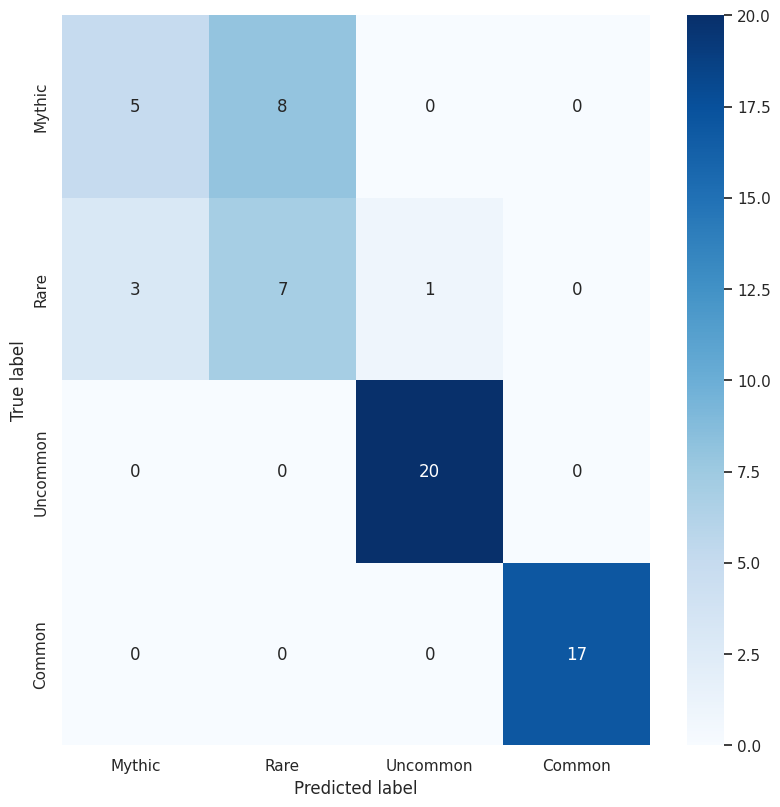

In [ ]:
class_names = ['Mythic', 'Rare', 'Uncommon', 'Common']


predictions = model.predict(x=test_set)
predictions = list(map(lambda x: np.argmax(x), predictions))

# Ahora graficamos
plot_confusion_matrix(labels=test_target, predictions=predictions, class_names=class_names)

# 4) Arquitectura #2

## 4.1 Extracción de la data

In [ ]:
# extracting data por the second architecture

raw_data_arch2 = pd.read_csv("MTG-OTJ-draft-card-ratings-2024-05-25.csv")

raw_data_arch2.head()

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Another Round,W,R,64972,6.27,7953,9.59,1690,3.6%,46.6%,259,NaN,402,NaN,661,40.4%,1029,50.6%,-10.2pp
1,Archangel of Tithes,W,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,54.6%,4325,55.8%,7277,55.3%,10927,52.9%,2.4pp
2,Armored Armadillo,W,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,50.0%,7265,50.8%,12686,50.4%,18704,51.3%,-0.9pp
3,Aven Interrupter,W,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,56.6%,10692,57.5%,18427,57.1%,26391,54.3%,2.8pp
4,Bounding Felidar,W,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,53.6%,20093,55.4%,33127,54.7%,52462,54.4%,0.3pp


## 4.2 Encoding data

### 4.2.1 Quitar valores nulos

In [ ]:
"""
Color       46
ATA          1
GP WR        8
OH WR       31
GD WR       23
GIH WR      16
GNS WR      12
IWD         16
"""



'\nColor       46\nATA          1\nGP WR        8\nOH WR       31\nGD WR       23\nGIH WR      16\nGNS WR      12\nIWD         16\n'

In [ ]:
no_null_dataset_arch2 = raw_data_arch1.copy()

no_null_dataset_arch2 = no_null_dataset_arch2.dropna()

no_null_dataset_arch2.head()


,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
1,Archangel of Tithes,W,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,54.6%,4325,55.8%,7277,55.3%,10927,52.9%,2.4pp
2,Armored Armadillo,W,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,50.0%,7265,50.8%,12686,50.4%,18704,51.3%,-0.9pp
3,Aven Interrupter,W,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,56.6%,10692,57.5%,18427,57.1%,26391,54.3%,2.8pp
4,Bounding Felidar,W,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,53.6%,20093,55.4%,33127,54.7%,52462,54.4%,0.3pp
5,Bovine Intervention,W,U,136473,6.33,12508,9.99,18372,24.9%,50.7%,2815,46.7%,4488,51.0%,7303,49.4%,11046,51.6%,-2.3pp


###4.2.2 Parseando porcentajes

In [ ]:
def parse_percentage(percentage_string):

  try:
    # Remove the "%" symbol and convert to a float.
    percentage_value = float(percentage_string[:-1])

    # Convert the percentage to a value between 0 and 1.
    return percentage_value / 100


  except (ValueError, IndexError):
    return None


In [ ]:
def parse_IWD(IWD_string):

  try:

    IWD_value = float(IWD_string[:-2])


    return IWD_value

  except (ValueError, IndexError):
    return None

###4.2.3 Rarity - Ordinal Encoding

In [ ]:
# M -> Mythic
# R -> Rare
# U -> Uncommon
# C -> Common


def parse_rarity(rarity_string):

  if rarity_string == 'M':
    return 0
  elif rarity_string == 'R':
    return 1
  elif rarity_string == 'U':
    return 2
  elif rarity_string == 'C':
    return 3
  else:
    return None

  return None



###4.2.4 One Hot Encoding - Color

In [ ]:
no_null_dataset_arch2 = pd.get_dummies(no_null_dataset_arch2, columns=['Color'])
no_null_dataset_arch2.head()

,Name,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,Archangel of Tithes,M,9905,2.08,3697,2.15,18171,82.7%,53.9%,2952,...,False,True,False,False,False,False,False,False,False,False
2,Armored Armadillo,C,378941,7.89,40803,11.61,31423,12.9%,51.0%,5421,...,False,True,False,False,False,False,False,False,False,False
3,Aven Interrupter,R,24080,2.42,8609,2.64,44852,86.6%,55.5%,7735,...,False,True,False,False,False,False,False,False,False,False
4,Bounding Felidar,U,98493,4.11,18079,5.53,86683,80.2%,54.6%,13034,...,False,True,False,False,False,False,False,False,False,False
5,Bovine Intervention,U,136473,6.33,12508,9.99,18372,24.9%,50.7%,2815,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
one_hot_dataset_arch2 = no_null_dataset_arch2.copy()

In [ ]:
def boolean_to_int(value):
  if value == True:
    return 1
  elif value == False:
    return 0
  else:
    return None


In [ ]:
one_hot_dataset_arch2['Color_UBG'] = one_hot_dataset_arch2['Color_UBG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WBG'] = one_hot_dataset_arch2['Color_WBG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_URG'] = one_hot_dataset_arch2['Color_URG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_UBR'] = one_hot_dataset_arch2['Color_UBR'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WUG'] = one_hot_dataset_arch2['Color_WUG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WUB'] = one_hot_dataset_arch2['Color_WUB'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WRG'] = one_hot_dataset_arch2['Color_WRG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_UB'] = one_hot_dataset_arch2['Color_UB'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_UR'] = one_hot_dataset_arch2['Color_UR'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_BR'] = one_hot_dataset_arch2['Color_BR'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WR'] = one_hot_dataset_arch2['Color_WR'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_RG'] = one_hot_dataset_arch2['Color_RG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WG'] = one_hot_dataset_arch2['Color_WG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_UG'] = one_hot_dataset_arch2['Color_UG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_BG'] = one_hot_dataset_arch2['Color_BG'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WU'] = one_hot_dataset_arch2['Color_WU'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_WB'] = one_hot_dataset_arch2['Color_WB'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_W'] = one_hot_dataset_arch2['Color_W'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_B'] = one_hot_dataset_arch2['Color_B'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_R'] = one_hot_dataset_arch2['Color_R'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_G'] = one_hot_dataset_arch2['Color_G'].apply(boolean_to_int)
one_hot_dataset_arch2['Color_U'] = one_hot_dataset_arch2['Color_U'].apply(boolean_to_int)

In [ ]:
one_hot_dataset_arch2['Rarity'] = one_hot_dataset_arch2['Rarity'].apply(parse_rarity)
one_hot_dataset_arch2['IWD'] = one_hot_dataset_arch2['IWD'].apply(parse_IWD)

one_hot_dataset_arch2['% GP'] = one_hot_dataset_arch2['% GP'].apply(parse_percentage)
one_hot_dataset_arch2['GP WR'] = one_hot_dataset_arch2['GP WR'].apply(parse_percentage)
one_hot_dataset_arch2['OH WR'] = one_hot_dataset_arch2['OH WR'].apply(parse_percentage)
one_hot_dataset_arch2['GD WR'] = one_hot_dataset_arch2['GD WR'].apply(parse_percentage)
one_hot_dataset_arch2['GIH WR'] = one_hot_dataset_arch2['GIH WR'].apply(parse_percentage)
one_hot_dataset_arch2['GNS WR'] = one_hot_dataset_arch2['GNS WR'].apply(parse_percentage)


encoded_dataset = one_hot_dataset_arch2.copy()

In [ ]:
encoded_dataset

,Name,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,Archangel of Tithes,0,9905,2.08,3697,2.15,18171,0.827,0.539,2952,...,0,1,0,0,0,0,0,0,0,0
2,Armored Armadillo,3,378941,7.89,40803,11.61,31423,0.129,0.510,5421,...,0,1,0,0,0,0,0,0,0,0
3,Aven Interrupter,1,24080,2.42,8609,2.64,44852,0.866,0.555,7735,...,0,1,0,0,0,0,0,0,0,0
4,Bounding Felidar,2,98493,4.11,18079,5.53,86683,0.802,0.546,13034,...,0,1,0,0,0,0,0,0,0,0
5,Bovine Intervention,2,136473,6.33,12508,9.99,18372,0.249,0.507,2815,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,Tyrant's Scorn,2,116603,5.16,22058,6.77,90483,0.694,0.533,15541,...,0,0,0,0,0,0,0,0,0,0
367,Vanishing Verse,1,25985,4.34,5123,5.60,21558,0.695,0.553,3678,...,0,0,1,0,0,0,0,0,0,0
368,Villainous Wealth,1,20820,3.64,6396,4.13,28862,0.776,0.520,4610,...,0,0,0,0,0,0,0,0,0,0
369,Void Rend,1,34513,5.82,4703,8.59,7301,0.263,0.511,1233,...,0,0,0,0,0,0,0,0,1,0


##4.3 Matriz de correlación

In [ ]:
#drop Name column

encoded_dataset = encoded_dataset.drop(columns=['Name'])

<Axes: >

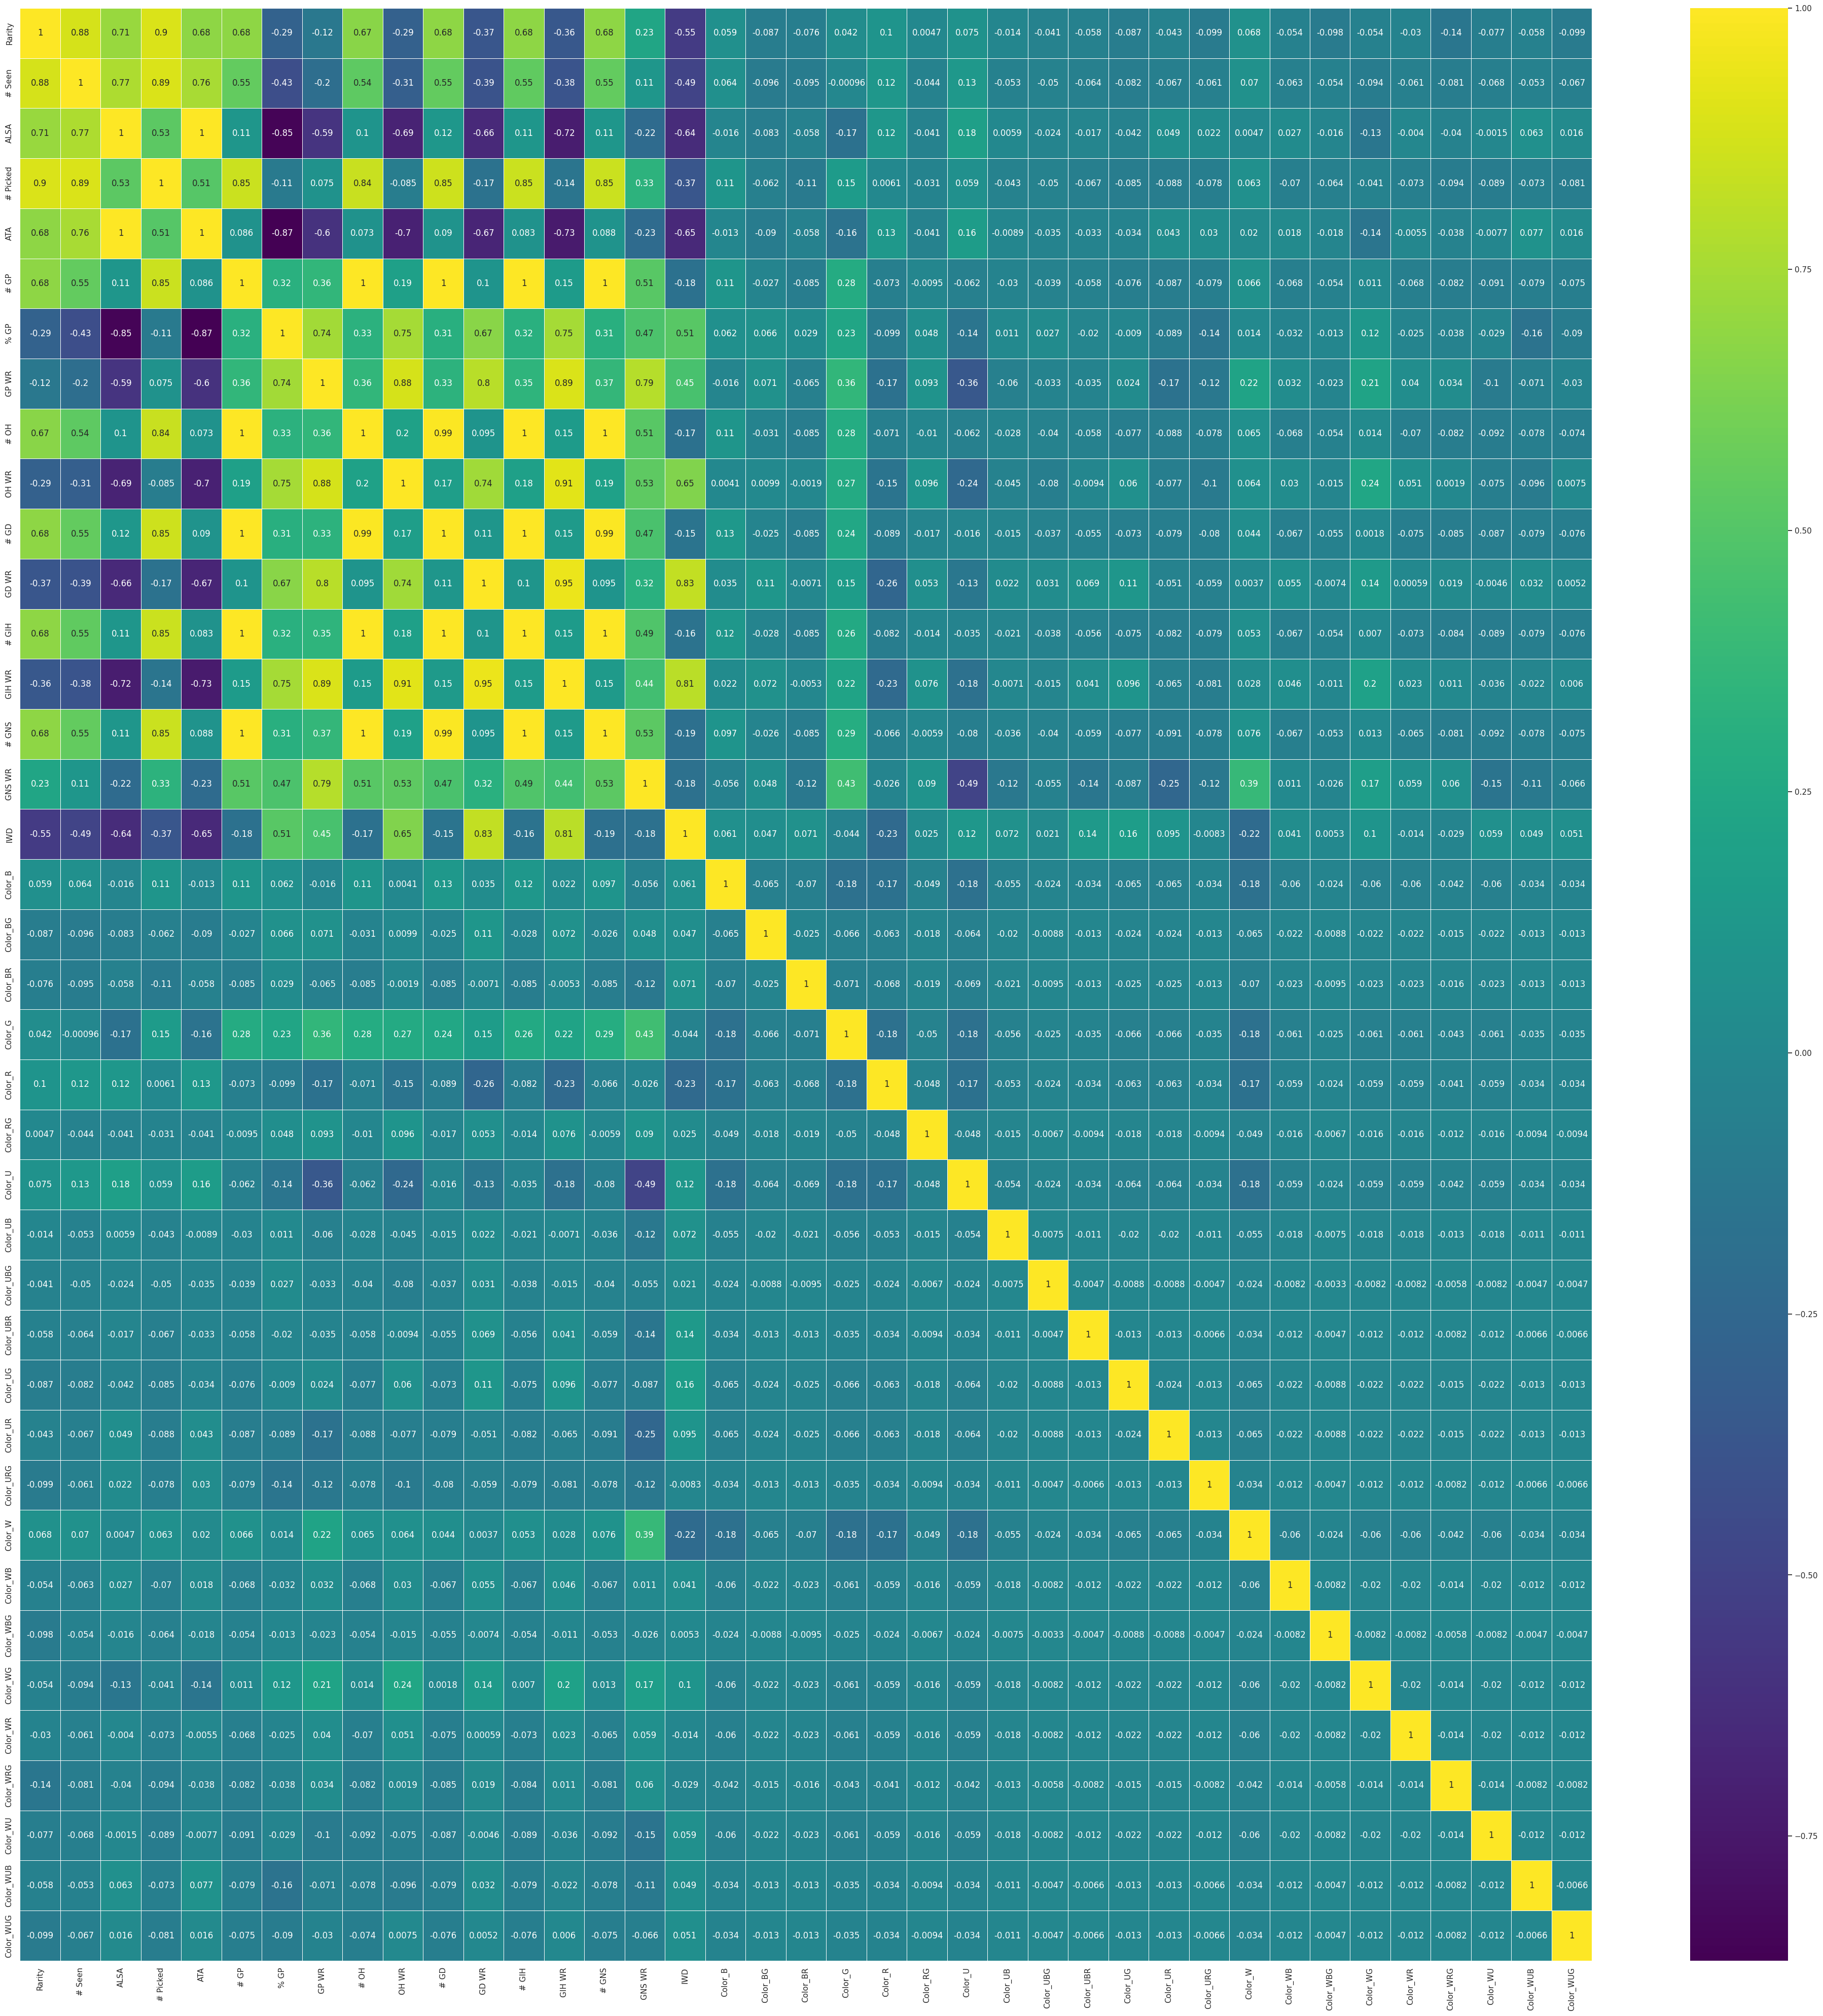

In [ ]:
correlation_matrix = encoded_dataset.corr()

# Plotting a heatmap
plt.figure(figsize=(50,50))
sns.heatmap(correlation_matrix, linewidths=.5, cmap='viridis', annot=True)

In [ ]:
#vamos a quitar algunas columnas


encoded_dataset.drop(columns=['% GP','GP WR', 'OH WR', 'GNS WR'], inplace=True)

In [ ]:
encoded_dataset

,Rarity,# Seen,ALSA,# Picked,ATA,# GP,# OH,# GD,GD WR,# GIH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,0,9905,2.08,3697,2.15,18171,2952,4325,0.558,7277,...,0,1,0,0,0,0,0,0,0,0
2,3,378941,7.89,40803,11.61,31423,5421,7265,0.508,12686,...,0,1,0,0,0,0,0,0,0,0
3,1,24080,2.42,8609,2.64,44852,7735,10692,0.575,18427,...,0,1,0,0,0,0,0,0,0,0
4,2,98493,4.11,18079,5.53,86683,13034,20093,0.554,33127,...,0,1,0,0,0,0,0,0,0,0
5,2,136473,6.33,12508,9.99,18372,2815,4488,0.510,7303,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,2,116603,5.16,22058,6.77,90483,15541,25803,0.589,41344,...,0,0,0,0,0,0,0,0,0,0
367,1,25985,4.34,5123,5.60,21558,3678,5474,0.607,9152,...,0,0,1,0,0,0,0,0,0,0
368,1,20820,3.64,6396,4.13,28862,4610,7951,0.579,12561,...,0,0,0,0,0,0,0,0,0,0
369,1,34513,5.82,4703,8.59,7301,1233,2002,0.579,3235,...,0,0,0,0,0,0,0,0,1,0


##4.4 Normalizacion

In [ ]:
normalized_dataset_arch2 = encoded_dataset.copy()

In [ ]:
def z_normalization(column):
    return (column - column.mean()) / column.std()

In [ ]:
normalized_dataset_arch2['# Seen'] = z_normalization(normalized_dataset_arch2['# Seen'])
normalized_dataset_arch2['# Picked'] = z_normalization(normalized_dataset_arch2['# Picked'])
normalized_dataset_arch2['# GP'] = z_normalization(normalized_dataset_arch2['# GP'])
normalized_dataset_arch2['# OH'] = z_normalization(normalized_dataset_arch2['# OH'])
normalized_dataset_arch2['# GD'] = z_normalization(normalized_dataset_arch2['# GD'])
normalized_dataset_arch2['# GIH'] = z_normalization(normalized_dataset_arch2['# GIH'])
normalized_dataset_arch2['# GNS'] = z_normalization(normalized_dataset_arch2['# GNS'])



In [ ]:
normalized_dataset_arch2

,Rarity,# Seen,ALSA,# Picked,ATA,# GP,# OH,# GD,GD WR,# GIH,...,Color_URG,Color_W,Color_WB,Color_WBG,Color_WG,Color_WR,Color_WRG,Color_WU,Color_WUB,Color_WUG
1,0,-0.953446,2.08,-1.026450,2.15,-0.809275,-0.808170,-0.832080,0.558,-0.823638,...,0,1,0,0,0,0,0,0,0,0
2,3,1.997987,7.89,1.065757,11.61,-0.645315,-0.629850,-0.681770,0.508,-0.661430,...,0,1,0,0,0,0,0,0,0,0
3,1,-0.840079,2.42,-0.749489,2.64,-0.479165,-0.462725,-0.506562,0.575,-0.489265,...,0,1,0,0,0,0,0,0,0,0
4,2,-0.244947,4.11,-0.215526,5.53,0.038388,-0.080013,-0.025928,0.554,-0.048432,...,0,1,0,0,0,0,0,0,0,0
5,2,0.058805,6.33,-0.529645,9.99,-0.806788,-0.818064,-0.823746,0.510,-0.822858,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,2,-0.100109,5.16,0.008828,6.77,0.085403,0.101051,0.266000,0.589,0.197985,...,0,0,0,0,0,0,0,0,0,0
367,1,-0.824843,4.34,-0.946045,5.60,-0.767369,-0.755735,-0.773336,0.607,-0.767409,...,0,0,1,0,0,0,0,0,0,0
368,1,-0.866151,3.64,-0.874268,4.13,-0.677001,-0.688423,-0.646698,0.579,-0.665178,...,0,0,0,0,0,0,0,0,0,0
369,1,-0.756639,5.82,-0.969727,8.59,-0.943764,-0.932322,-0.950845,0.579,-0.944852,...,0,0,0,0,0,0,0,0,1,0


##4.5 Balance de datos

Class 0 :  45
Class 3 :  75
Class 1 :  73
Class 2 :  110


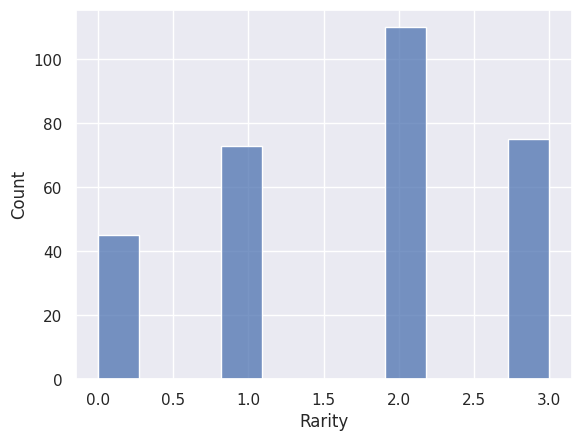

In [ ]:
for i in normalized_dataset_arch2["Rarity"].unique():
  numRows = len(normalized_dataset_arch2[normalized_dataset_arch2['Rarity'] == i])
  print("Class", i, ": ", numRows)

# Setting style of the graph
sns.set(style="darkgrid")

# Plotting a histogram
sns.histplot(data=normalized_dataset_arch2, x="Rarity")
plt.show()

In [ ]:
values = normalized_dataset_arch2['Rarity'].value_counts()

In [ ]:
#lets undersample class 2 to class 1 amount

class_one_count = values[1]

undersampled_class_two = normalized_dataset_arch2[normalized_dataset_arch2['Rarity'] == 2].sample(class_one_count, replace=False)
undersampled_class_three = normalized_dataset_arch2[normalized_dataset_arch2['Rarity'] == 3].sample(class_one_count, replace=False)

#lets oversample class 0 to class 1
oversampled_class_zero = normalized_dataset_arch2[normalized_dataset_arch2['Rarity'] == 0].sample(class_one_count, replace=True)

In [ ]:
class_one_dataset = normalized_dataset_arch2[normalized_dataset_arch2['Rarity'] == 1]

balanced_dataset = pd.concat([class_one_dataset, undersampled_class_two, undersampled_class_three, oversampled_class_zero])

balanced_dataset = balanced_dataset.sample(frac=1).reset_index(drop=True)

Class 3 :  73
Class 2 :  73
Class 1 :  73
Class 0 :  73


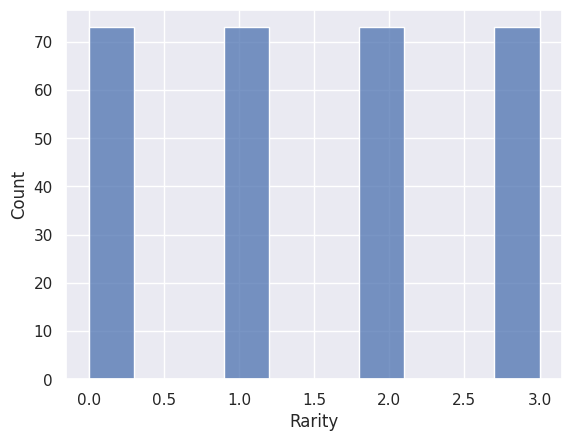

In [ ]:
for i in balanced_dataset["Rarity"].unique():
  numRows = len(balanced_dataset[balanced_dataset['Rarity'] == i])
  print("Class", i, ": ", numRows)

# Setting style of the graph
sns.set(style="darkgrid")

# Plotting a histogram
sns.histplot(data=balanced_dataset, x="Rarity")
plt.show()

##4.3 Modelo AI

### 4.3.1 Callback

In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=4,)

###4.3.2 Splitting Variables

In [ ]:
train, test = train_test_split(balanced_dataset, test_size=0.2)


""" ['Color_B', 'Color_BG', 'Color_BR', 'Color_G',
       'Color_R', 'Color_RG', 'Color_U', 'Color_UB', 'Color_UBG', 'Color_UBR',
       'Color_UG', 'Color_UR', 'Color_URG', 'Color_W', 'Color_WB', 'Color_WBG',
       'Color_WG', 'Color_WR', 'Color_WRG', 'Color_WU', 'Color_WUB',
       'Color_WUG','# Seen', '# Picked', '# GP', '# OH', '# GIH', '# GNS']"""

independent_variables = list(balanced_dataset.columns)
independent_variables.remove('Rarity')
dependent_variables = ['Rarity']

train_set2 = train[independent_variables]
train_target2 = train[dependent_variables]

test_set2 = test[independent_variables]
test_target2 = test[dependent_variables]

In [ ]:
#now lets build the model

model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(independent_variables),)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax')
])


# Compile the Keras model, not the DataFrame
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Fit the Keras model using the training data
model2.fit(train_set2, train_target2, epochs=50, batch_size = 128, validation_split=0.2, callbacks=[earlystopping_callback])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.2795 - loss: 1.4378 - val_accuracy: 0.2979 - val_loss: 1.3525
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3909 - loss: 1.2980 - val_accuracy: 0.3191 - val_loss: 1.2584
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4479 - loss: 1.1976 - val_accuracy: 0.4468 - val_loss: 1.1855
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5860 - loss: 1.0970 - val_accuracy: 0.5106 - val_loss: 1.1292
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6283 - loss: 1.0425 - val_accuracy: 0.4681 - val_loss: 1.0838
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6541 - loss: 0.9817 - val_accuracy: 0.5106 - val_loss: 1.0458
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6606 - loss: 0.9529 - val_accuracy: 0.5319 - val_loss: 1.0128
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6700 - loss: 0.9166 - val_accuracy: 0.5319 - val_loss: 0.9839
Epoch 9/50

###4.3.3 Evaluation

In [ ]:
model2.evaluate(x=test_set2, y=test_target2, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8644 - loss: 0.4310


[0.43104127049446106, 0.8644067645072937]

##4.2 Matriz de confusión

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


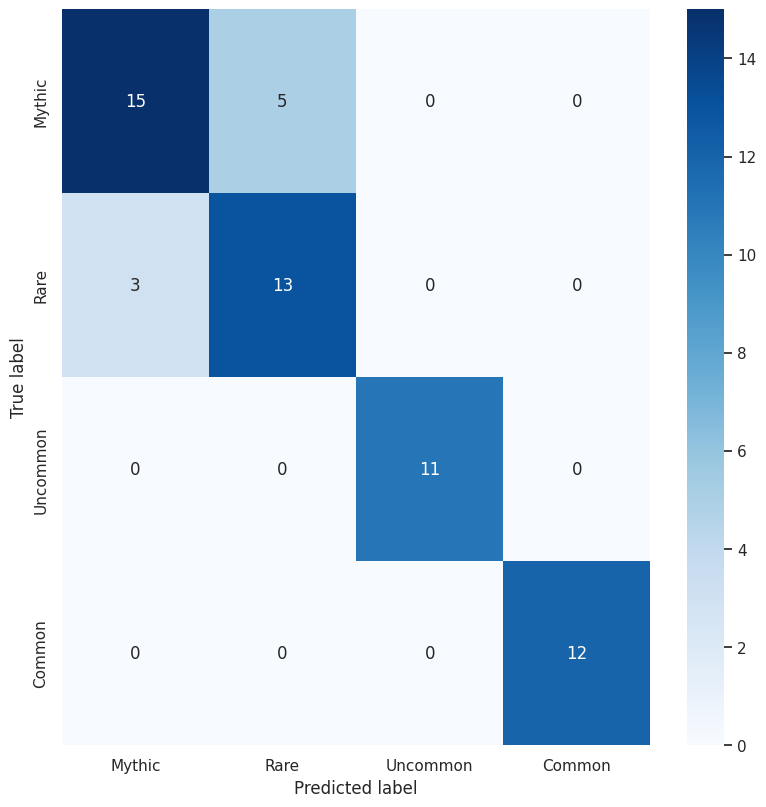

In [ ]:
class_names = ['Mythic', 'Rare', 'Uncommon', 'Common']


predictions = model2.predict(x=test_set2)
predictions = list(map(lambda x: np.argmax(x), predictions))

# Ahora graficamos
plot_confusion_matrix(labels=test_target2, predictions=predictions, class_names=class_names)

#5) Arquitectura #3